# Сегментация родинок и меланом
*Домашка с Deep Learning School*

В этом задании нужно решить задачу сегментации медицинских снимков.




---


1. Для начала скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>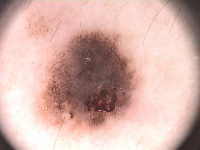</td><td>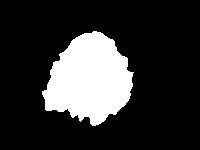</td></tr></table>

2. Разархивируем .rar файл.
3. Папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [ ]:
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar


--2021-05-31 16:15:04--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2021-05-31 16:15:04--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucabe346f81045bb11c276c3e89a.dl.dropboxusercontent.com/cd/0/inline/BPi_irFf6LQzA5OxT6IgmanrhEW3MpjX3FYQE1ZWSutIZ7aH-f70ugrDvdxvANVX-KCek4EMbpQ-1YARTbzeVMozqonjiL90g5fXfoQes8F-LvoOn_q6kKmJZx7YNDrVp0z50IVVrpQIokgH8ITXm3zz/file# [following]
--2021-05-31 16:15:05--  https://ucabe346f81045bb11c276c3e89a.dl.dropboxusercontent.com/cd/0/inline/BPi_irFf6LQzA5OxT6IgmanrhEW3MpjX3FYQE1ZWSutIZ7aH-f70ugrDvdxvANVX-KCek4EMbpQ-1YART

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений будем использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, нарисуем несколько изображений

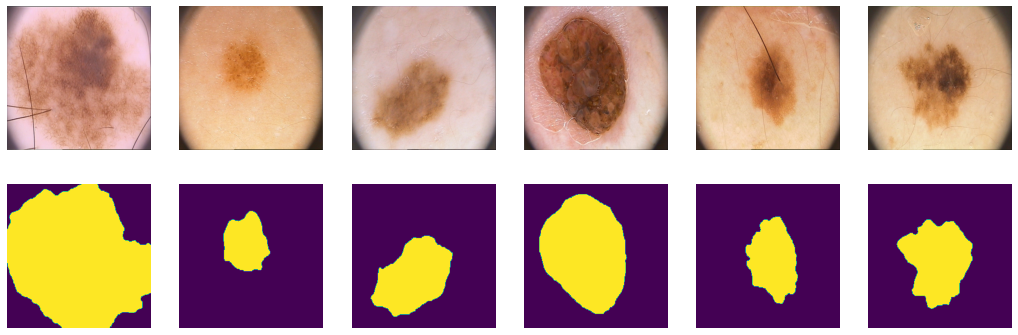

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Нужно написать несколько нейросетевых архитектур для решения задачи семантической сегментации, сравнить их по качеству на тесте и испробовать различные лосс функции для них.

В конце ноутбука будет приведен отчет со сравнением всех обученных сетей.


-----------------------------------------------------------------------------------------

# SegNet

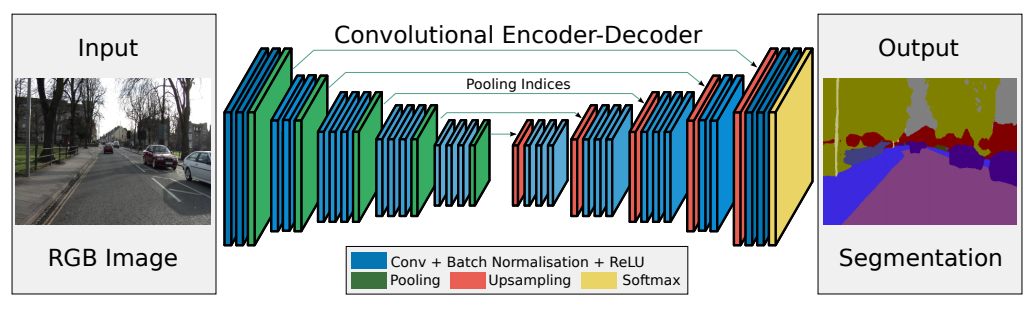


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))  # no activation
        return d3

## Метрика

Предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded 

## Функция потерь
Для начала воспользуемся *бинарной кросс-энтропией*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это логистическая функция.

Однако эта функция страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Выполним следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Новая функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    return (torch.clamp(y_pred, 0) - y_real * y_pred + torch.log(1 + torch.exp(-abs(y_pred)))).mean()

## Тренировка

Определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, metric, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    history = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_tr_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_tr_loss += loss / len(data_tr)

        metric_tr = score_model(model, metric, data_tr)

        avg_val_loss = 0
        model.eval()  # testing mode
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            with torch.no_grad():
                Y_pred = model(X_batch)
                loss = loss_fn(Y_batch, Y_pred)
                avg_val_loss += loss / len(data_val)

        metric_val = score_model(model, metric, data_val)

        history.append((avg_tr_loss, metric_tr, avg_val_loss, metric_val))

        toc = time()
        print('loss: %f' % avg_tr_loss)

        # show intermediate results
        Y_hat = (model(X_val.to(device)) > 0.5).detach().cpu() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_tr_loss))
        plt.show()
    
    return history

Функция для отрисовки графиков лосса и точности модели:

In [ ]:
def show_history(history):
    loss, acc, val_loss, val_acc = zip(*history)

    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

    plt.figure(figsize=(15, 9))
    plt.plot(acc, label="train_iou")
    plt.plot(val_acc, label="val_iou")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.show()

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = model(data.to(device)).cpu() > 0.5
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = (model(X_batch.to(device)) > 0.5)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Обучение моделей


In [ ]:
segnet_bce = SegNet().to(device)

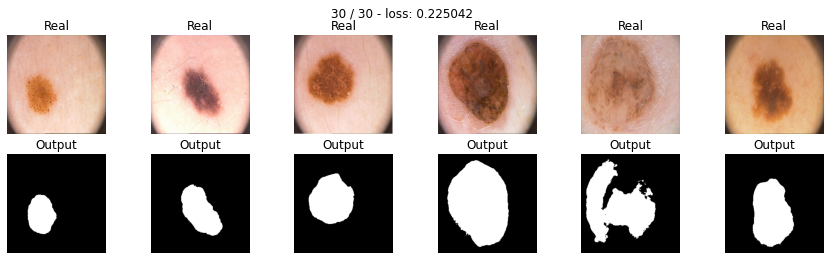

In [ ]:
max_epochs = 30
opt = optim.Adam(segnet_bce.parameters(), lr=3e-4)
bce_history = train(segnet_bce, opt, bce_loss, iou_pytorch, max_epochs, data_tr, data_val)

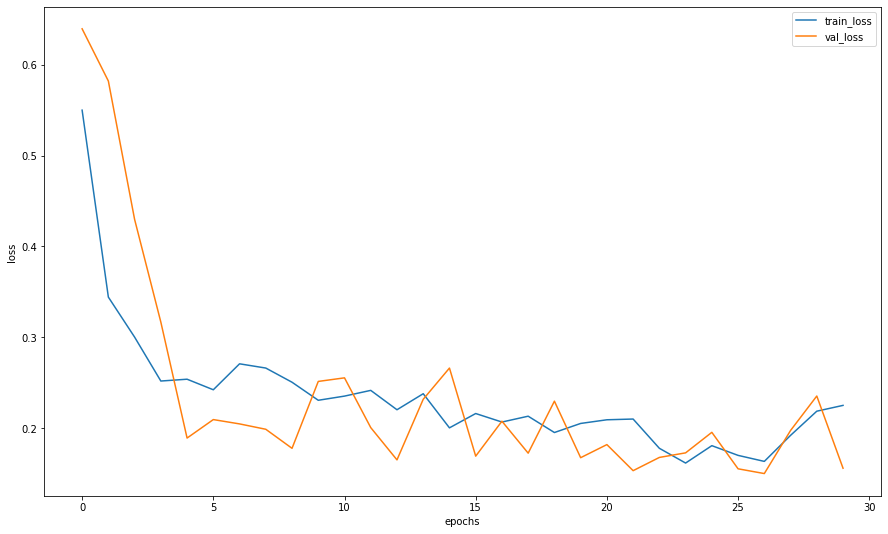

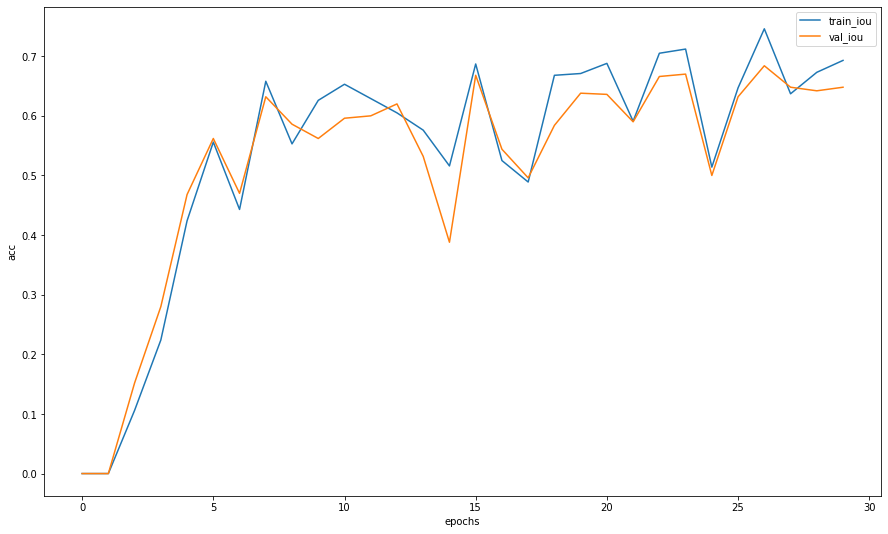

In [ ]:
show_history(bce_history)

In [ ]:
score_model(segnet_bce, iou_pytorch, data_ts)

0.6460000038146972

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

Попробуем обучить модель с использованием других лоссов.

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но для градиентного спуска дифференцируемость необходима. В данном случае мы можем выполнить следующее приближение:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$


In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    smooth = 1e-8
    num = (y_real * y_pred).sum()
    den = (y_real + y_pred).sum()
    dice = (2 * num + smooth) / (den + smooth)
    return 1 - dice

Проводим тестирование:

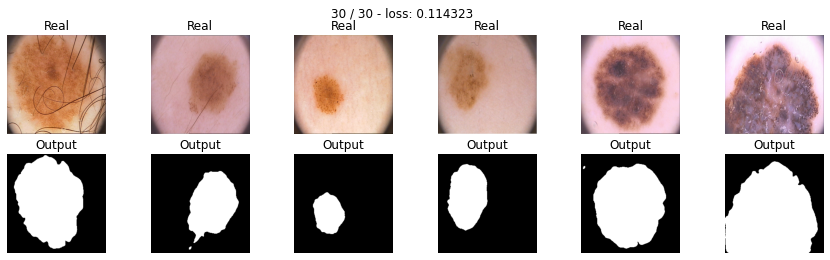

In [ ]:
segnet_dice = SegNet().to(device)

max_epochs = 30
opt = optim.Adam(segnet_dice.parameters(), lr=3e-4)
dice_history = train(segnet_dice, opt, dice_loss, iou_pytorch, max_epochs, data_tr, data_val)

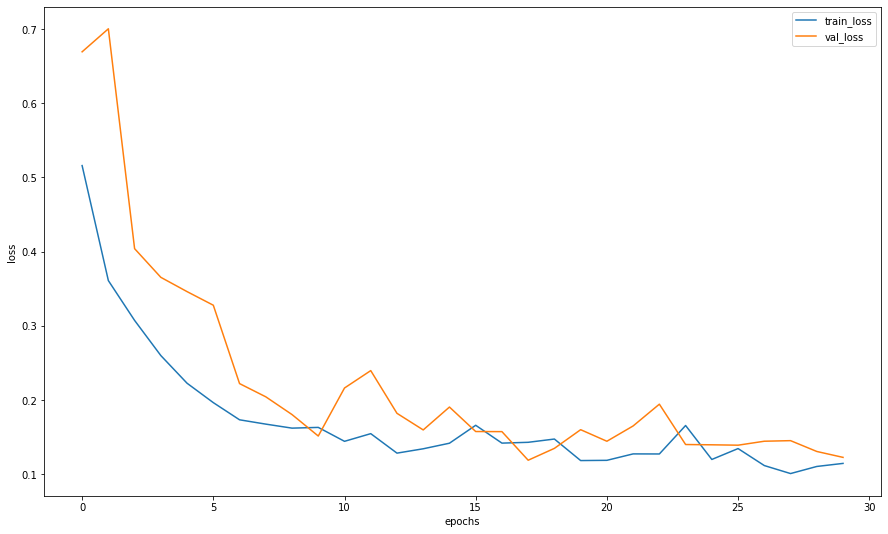

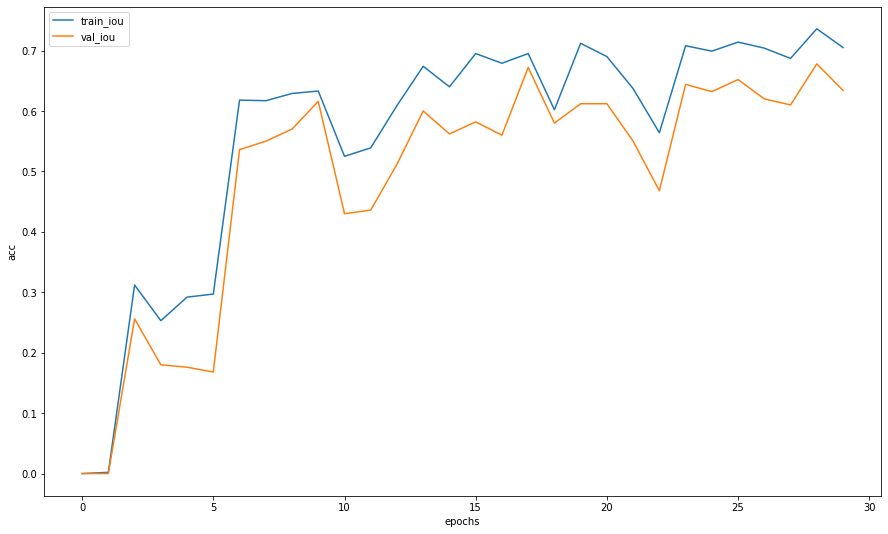

In [ ]:
show_history(dice_history)

In [ ]:
score_model(segnet_dice, iou_pytorch, data_ts)

0.6560000300407409

2. Focal loss:

Вспомним BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой функцией заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** (переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(torch.sigmoid(y_pred), eps, 1-eps) # hint: torch.clamp
    return -((1 - y_pred)**gamma * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred)).mean()

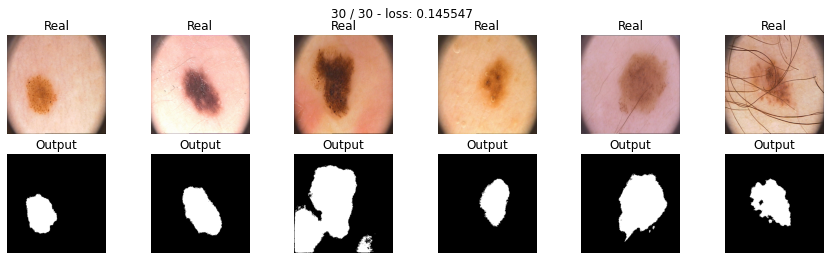

In [ ]:
segnet_focal = SegNet().to(device)

max_epochs = 30
opt = optim.Adam(segnet_focal.parameters(), lr=3e-4)
focal_history = train(segnet_focal, opt, focal_loss, iou_pytorch, max_epochs, data_tr, data_val)

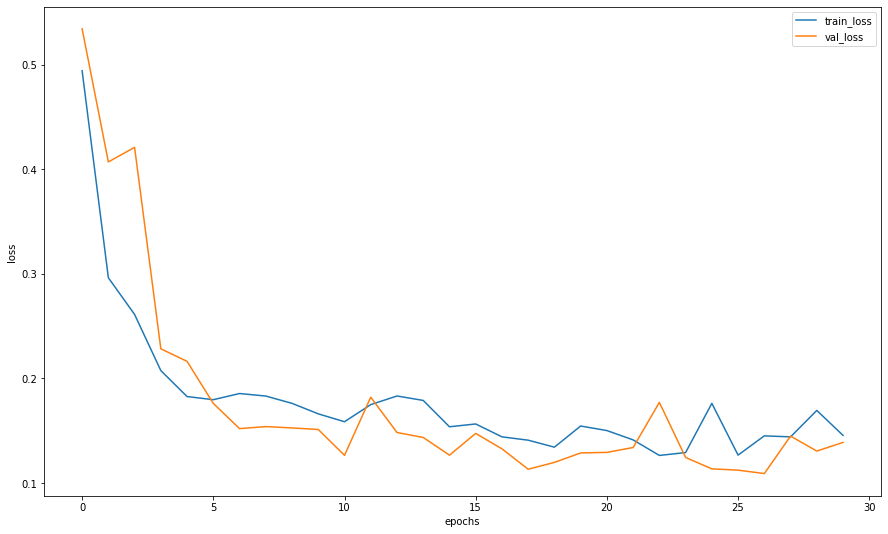

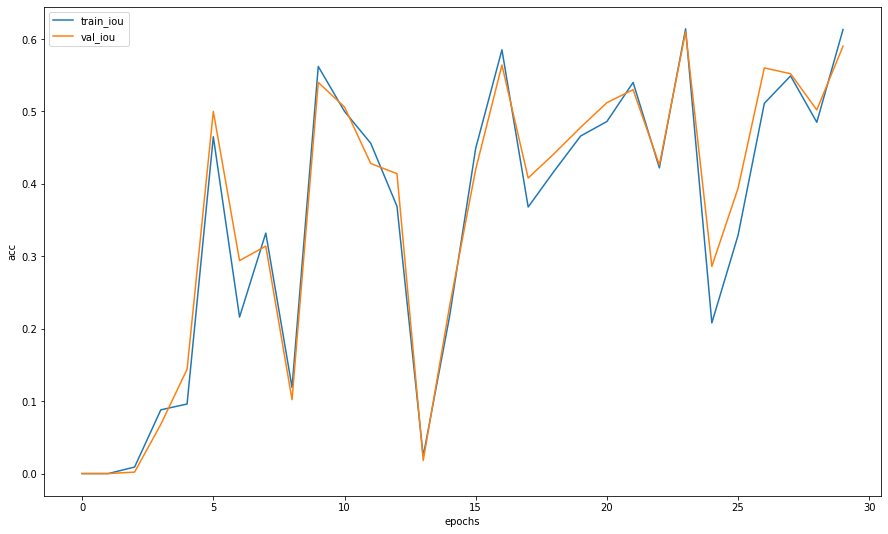

In [ ]:
show_history(focal_history)

In [ ]:
score_model(segnet_focal, iou_pytorch, data_val)

0.5900000333786011

-----------------------------------------------------------------------------------------

# U-Net

**U-Net** — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации, но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

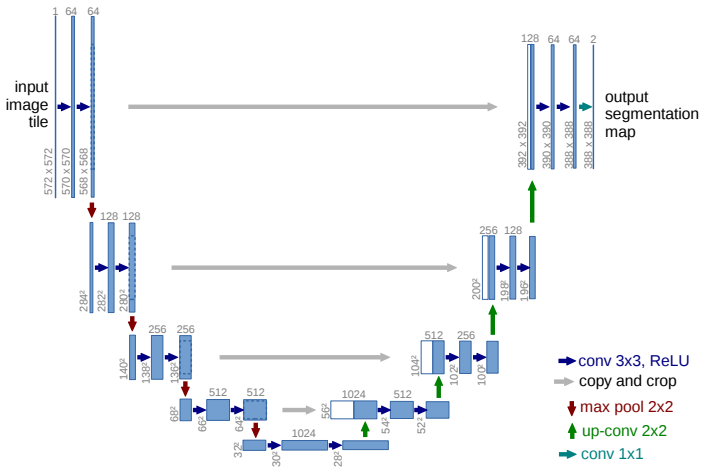

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.dec_conv0(torch.cat([e3, self.upsample0(b)], 1))
        d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0)], 1))
        d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1)], 1))
        d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2)], 1))  # no activation
        return d3

In [ ]:
unet_bce = UNet().to(device)

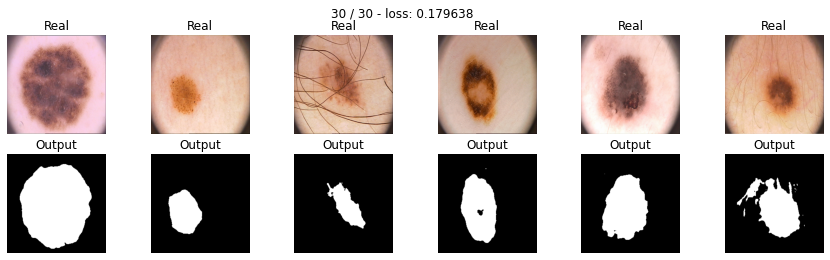

In [ ]:
bce_unet_history = train(unet_bce, optim.Adam(unet_bce.parameters(), lr=3e-4), bce_loss, iou_pytorch, 30, data_tr, data_val)

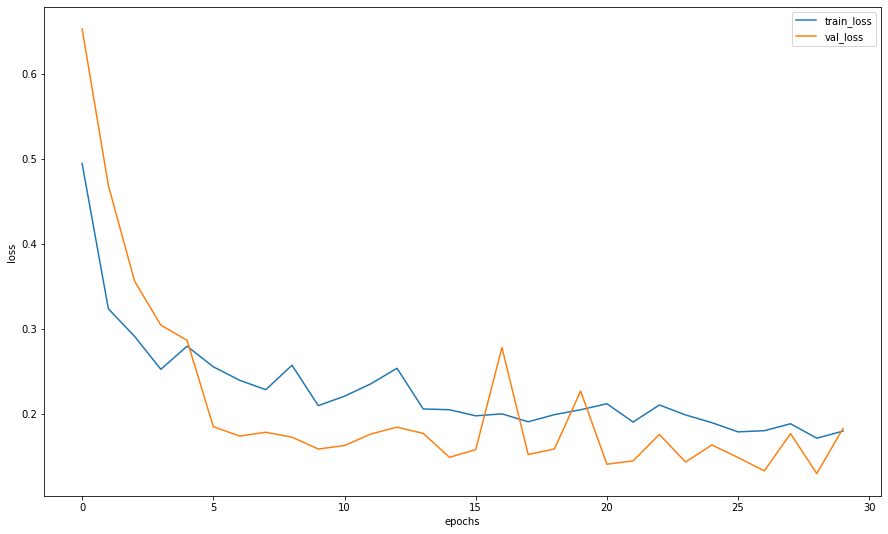

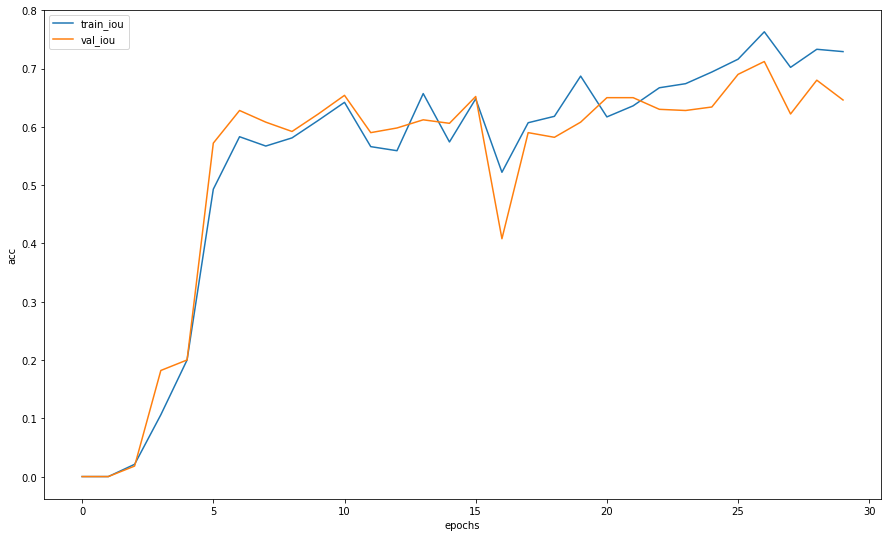

In [ ]:
show_history(bce_unet_history)

In [ ]:
score_model(unet_bce, iou_pytorch, data_val)

0.6459999918937683

Теперь проверим модель UNet c функцией потерь Dice.

In [ ]:
unet_dice = UNet().to(device)

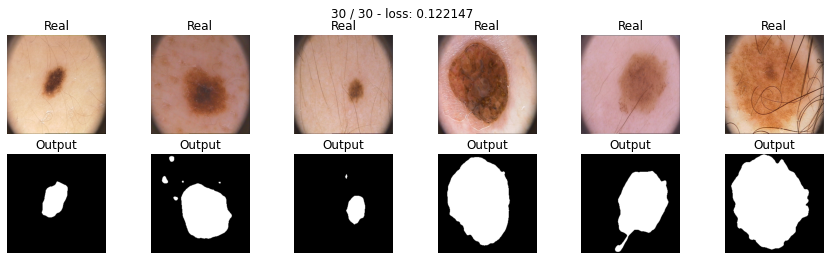

In [ ]:
dice_unet_history = train(unet_dice, optim.Adam(unet_dice.parameters(), lr=3e-4), dice_loss, iou_pytorch, 30, data_tr, data_val)

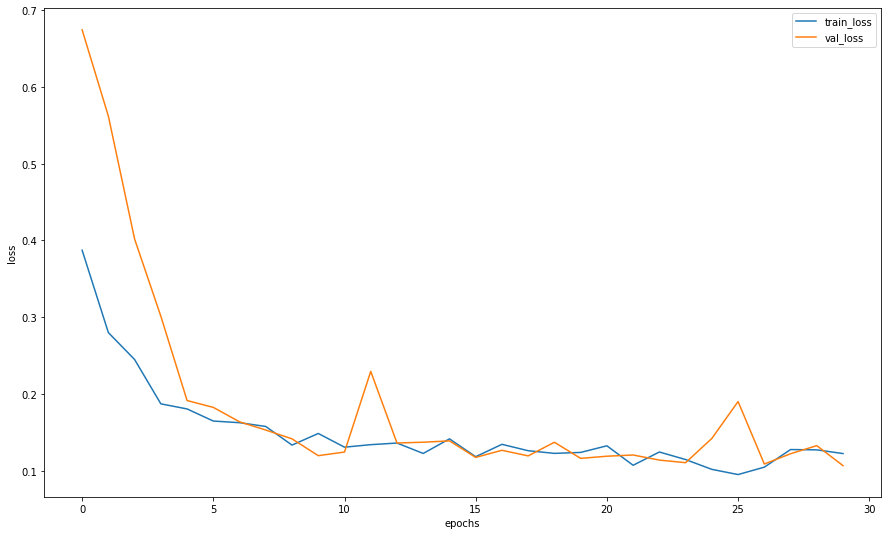

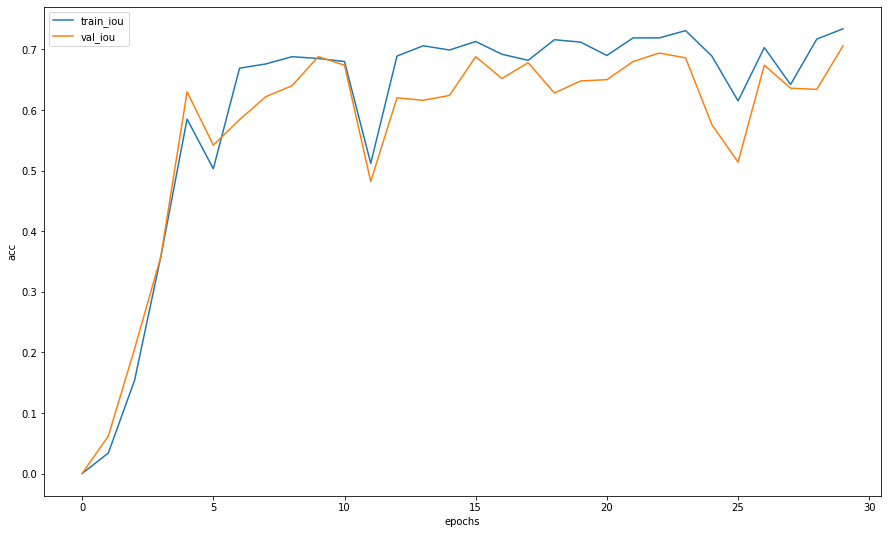

In [ ]:
show_history(dice_unet_history)

In [ ]:
score_model(unet_dice, iou_pytorch, data_val)

0.7060000181198121

И с функцией потерь Focal.

In [ ]:
unet_focal = UNet().to(device)

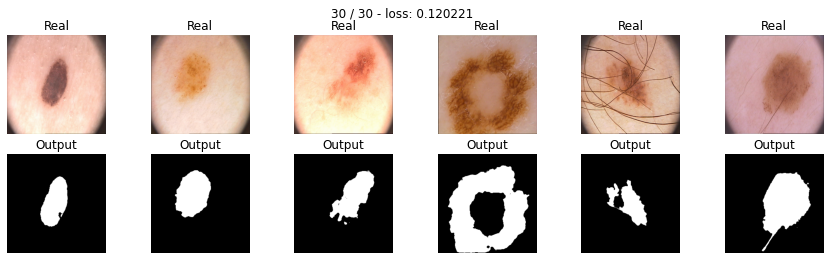

In [ ]:
focal_unet_history = train(unet_focal, optim.Adam(unet_focal.parameters(), lr=3e-4), focal_loss, iou_pytorch, 30, data_tr, data_val)

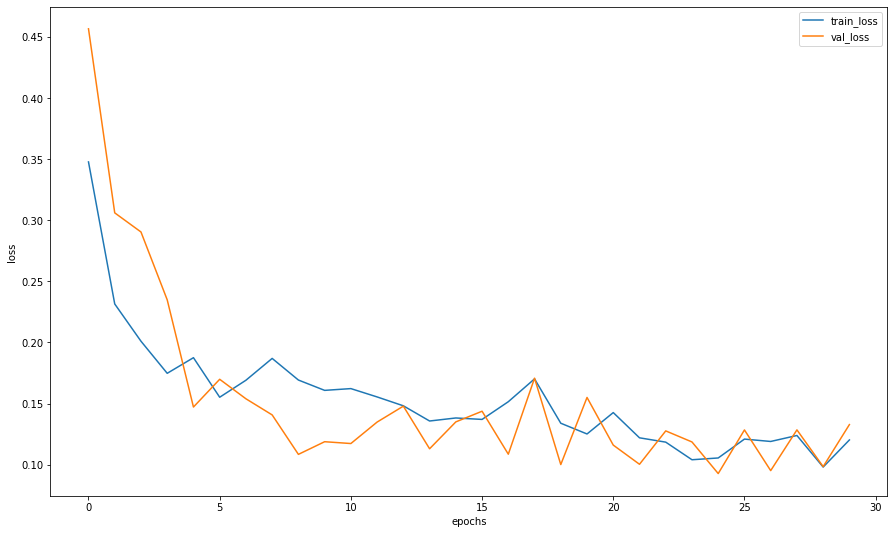

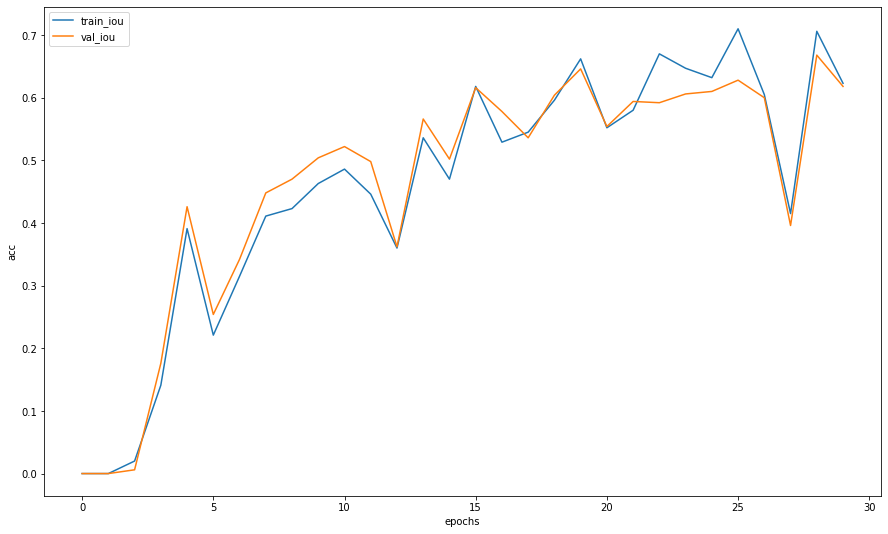

In [ ]:
show_history(focal_unet_history)

In [ ]:
score_model(unet_focal, iou_pytorch, data_val)

0.618000042438507

# Итоги


Была поставлена задача сегментации родинок и меланом с картинок. Для решения задачи использовались следующие архитектуры нейронных сетей:
* SegNet
* UNet

### Описание используемых архитектур
Сеть SegNet - это Fully Convolutional сеть, которую можно разделить на две части - encoder и decoder.

Encoder часть состоит из нескольких сверточных слоев и макспулингов. В этой части мы постепенно увеличиваем количество каналов с 3 до 512 (и соответственно уменьшаем размер карт активации). 

Полученные карты активации пропускаются через bottleneck - два сверточных слоя с ядром размера 1*1.

Задача decoder'а - "развернуть" полученные карты активации в картинку с одним каналом (т.е. черно-белую), размер которой равен размеру исходной картинки. Decoder часть состоят из сверточных слоев и максанпулингов.

В итоге получаем картинку с сегментированным объектом.

Архитектура UNet отличается лишь наличием skip connection'ов.

### Метрика и лосс

Для оценки качества работы моделей использовалась метрика IoU - Intersection over Union.

В работе использовались следующие лосс-функции:
* BCE loss
* Dice loss
* Focal loss

### Наглядное сравнение результатов

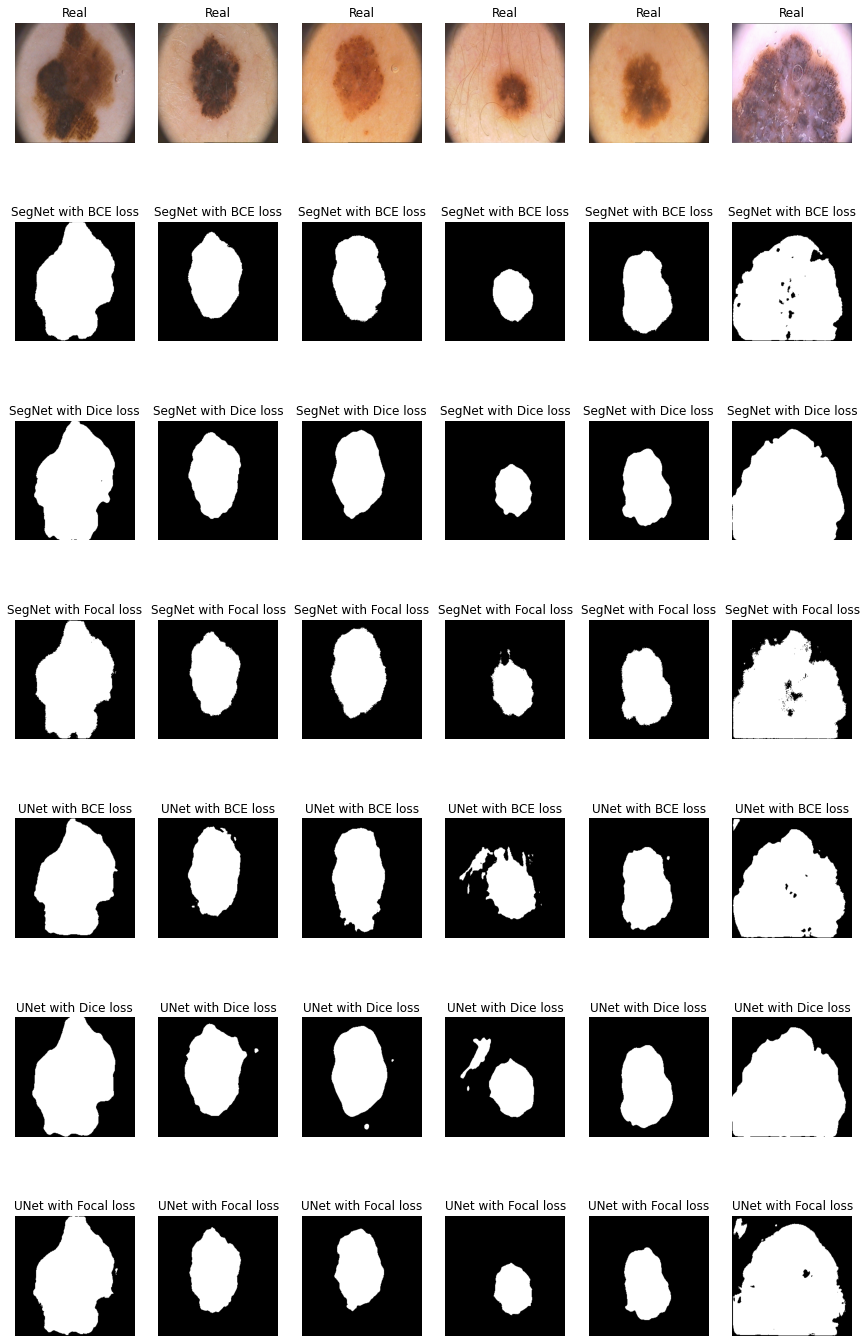

In [ ]:
X_val, Y_val = next(iter(data_val))

plt.figure(figsize=(15, 25))
for k in range(6):
    plt.subplot(7, 6, k+1)
    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(7, 6, k+7)
    plt.imshow(predict(segnet_bce, X_val)[k, 0], cmap='gray')
    plt.title('SegNet with BCE loss')
    plt.axis('off')

    plt.subplot(7, 6, k+13)
    plt.imshow(predict(segnet_dice, X_val)[k, 0], cmap='gray')
    plt.title('SegNet with Dice loss')
    plt.axis('off')

    plt.subplot(7, 6, k+19)
    plt.imshow(predict(segnet_focal, X_val)[k, 0], cmap='gray')
    plt.title('SegNet with Focal loss')
    plt.axis('off')

    plt.subplot(7, 6, k+25)
    plt.imshow(predict(unet_bce, X_val)[k, 0], cmap='gray')
    plt.title('UNet with BCE loss')
    plt.axis('off')

    plt.subplot(7, 6, k+31)
    plt.imshow(predict(unet_dice, X_val)[k, 0], cmap='gray')
    plt.title('UNet with Dice loss')
    plt.axis('off')

    plt.subplot(7, 6, k+37)
    plt.imshow(predict(unet_focal, X_val)[k, 0], cmap='gray')
    plt.title('UNet with Focal loss')
    plt.axis('off')

### Оценка качества моделей

Рассмотрим графики изменения лосс-функций на валидационной выборке для каждой модели. Обе модели обучались на 30 эпохах с одинаковым оптимизатором.

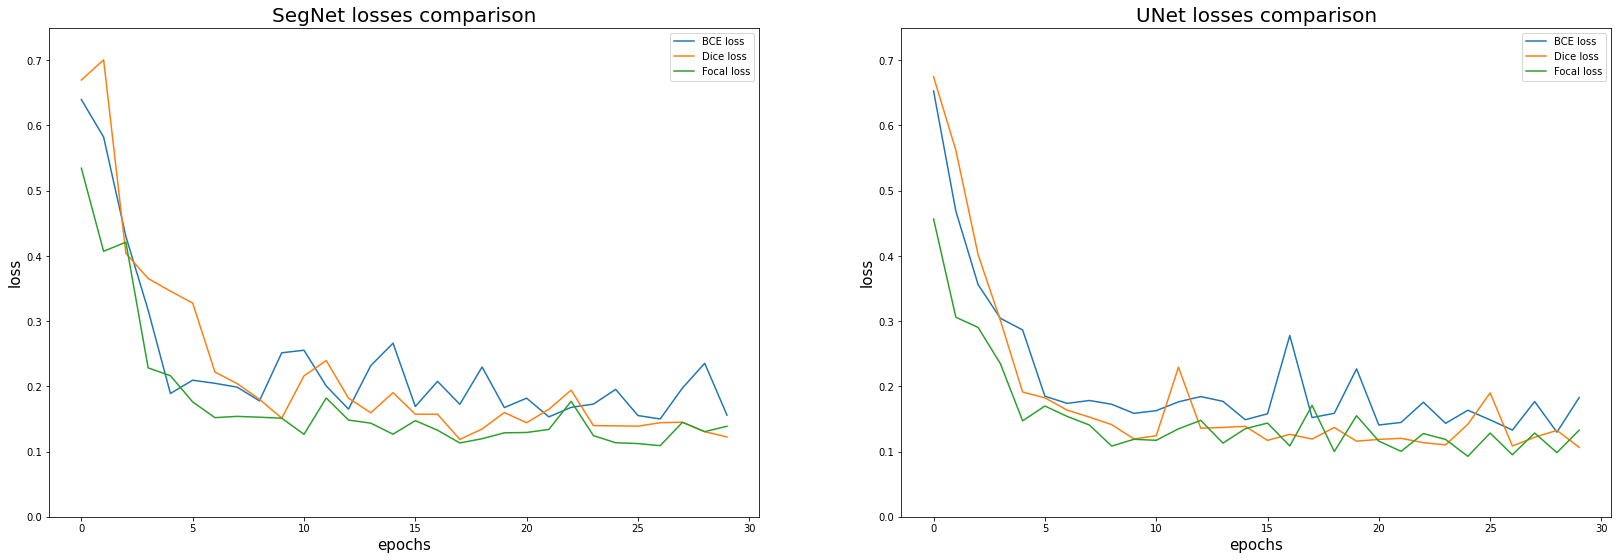

In [ ]:
_, _, bce_loss, _ = zip(*bce_history)
_, _, dice_loss, _ = zip(*dice_history)
_, _, focal_loss, _ = zip(*focal_history)
_, _, bce_unet_loss, _ = zip(*bce_unet_history)
_, _, dice_unet_loss, _ = zip(*dice_unet_history)
_, _, focal_unet_loss, _ = zip(*focal_unet_history)

plt.figure(figsize=(28, 9))

plt.subplot(1, 2, 1)
plt.plot(bce_loss, label="BCE loss")
plt.plot(dice_loss, label="Dice loss")
plt.plot(focal_loss, label="Focal loss")
plt.legend(loc='best')
plt.xlabel("epochs").set_fontsize(15)
plt.ylabel("loss").set_fontsize(15)
plt.ylim((0, 0.75))
plt.title("SegNet losses comparison").set_fontsize(20)

plt.subplot(1, 2, 2)
plt.plot(bce_unet_loss, label="BCE loss")
plt.plot(dice_unet_loss, label="Dice loss")
plt.plot(focal_unet_loss, label="Focal loss")
plt.legend(loc='best')
plt.xlabel("epochs").set_fontsize(15)
plt.ylabel("loss").set_fontsize(15)
plt.ylim((0, 0.75))
plt.title("UNet losses comparison").set_fontsize(20)

plt.show()

По графикам видно, что оба лосса сходятся примерно к одному и тому же значению. Скорость убывания графиков отличается незначительно. 

Отмечу, что при использовании BCE лосса появляется больше скачков на графике.

Можно заметить, что график focal лосса в основном располагается ниже двух других. А значит он хоть немного, но выигрывает у остальных лоссов.

Проверим, на какой модели фокал лосс убывает быстрее.

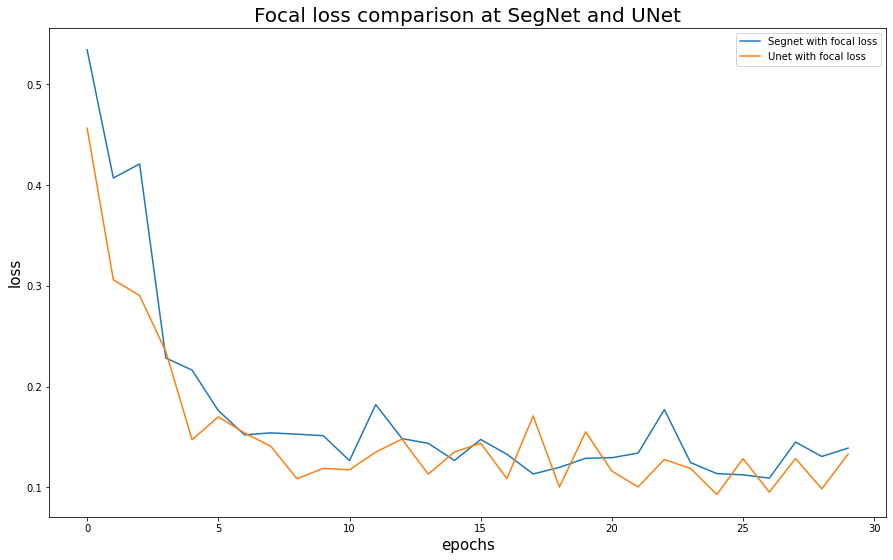

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(focal_loss, label="Segnet with focal loss")
plt.plot(focal_unet_loss, label="Unet with focal loss")
plt.legend(loc='best')
plt.xlabel("epochs").set_fontsize(15)
plt.ylabel("loss").set_fontsize(15)
plt.title("Focal loss comparison at SegNet and UNet").set_fontsize(20)
plt.show()

UNet с небольшим отрывом выигрывает. Однако этот отрыв не настолько большой, чтобы отказываться от SegNet'а и от остальных лоссов. В зависимости от состава валидационной выборки графики могут меняться местами. Поэтому очевидная выгода в использовании какой-то определенной комбинации модели+лосса пока что не обнаружена.

Построим аналогичные графики изменения значения метрики для SegNet'а и UNet'а.

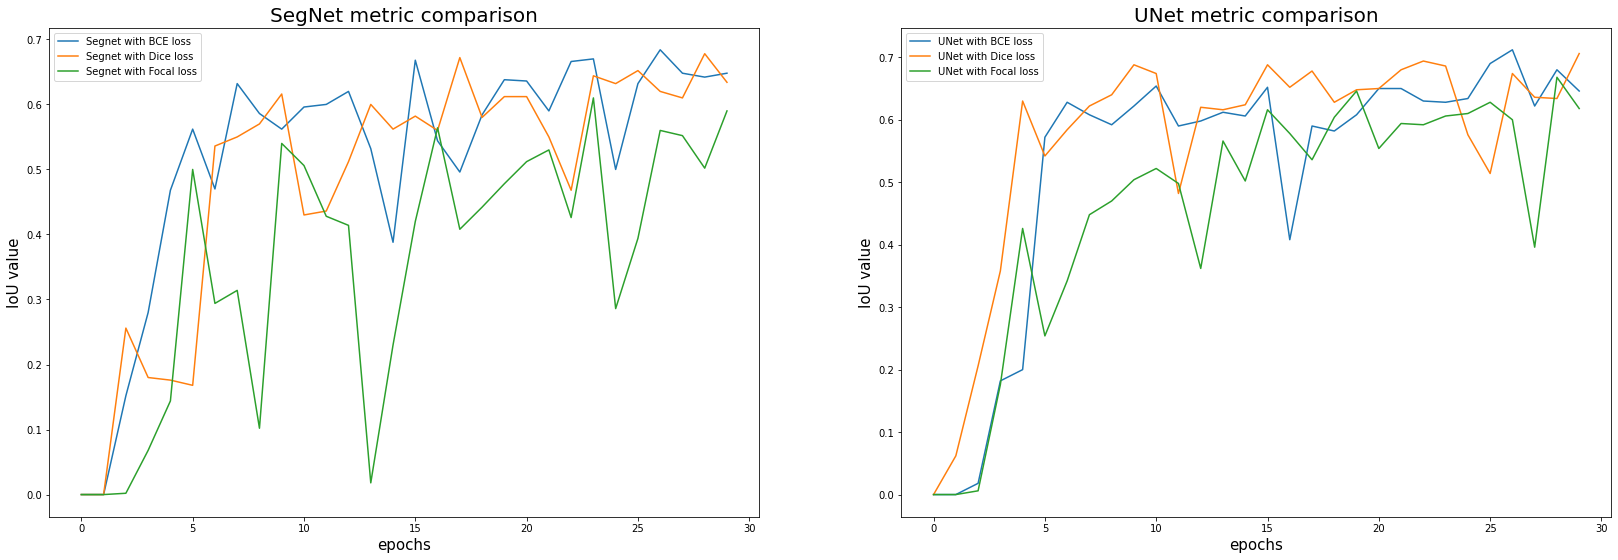

In [ ]:
_, _, _, bce_iou = zip(*bce_history)
_, _, _, dice_iou = zip(*dice_history)
_, _, _, focal_iou = zip(*focal_history)
_, _, _, bce_unet_iou = zip(*bce_unet_history)
_, _, _, dice_unet_iou = zip(*dice_unet_history)
_, _, _, focal_unet_iou = zip(*focal_unet_history)

plt.figure(figsize=(28, 9))

plt.subplot(1, 2, 1)
plt.plot(bce_iou, label="Segnet with BCE loss")
plt.plot(dice_iou, label="Segnet with Dice loss")
plt.plot(focal_iou, label="Segnet with Focal loss")
plt.legend(loc='best')
plt.xlabel("epochs").set_fontsize(15)
plt.ylabel("IoU value").set_fontsize(15)
plt.title("SegNet metric comparison").set_fontsize(20)

plt.subplot(1, 2, 2)
plt.plot(bce_unet_iou, label="UNet with BCE loss")
plt.plot(dice_unet_iou, label="UNet with Dice loss")
plt.plot(focal_unet_iou, label="UNet with Focal loss")
plt.legend(loc='best')
plt.xlabel("epochs").set_fontsize(15)
plt.ylabel("IoU value").set_fontsize(15)
plt.title("UNet metric comparison").set_fontsize(20)

plt.show()

Сразу бросаются в глаза частые "проседания" метрики при использовании фокал лосса. Это не очень критично, так как при желании можно запоминать состояние модели на пике значений IoU и использовать именно его.

В обоих случаях метрика при использовании BCE и Dice выше, чем при использовании Focal loss. Но нужно учитывать, что у фокала есть гиперпараметр $\gamma$, регулируя который можно изменить поведение модели. В своей работе я этим не занимался.

Метрика на UNet растет быстрее. Это связано с использованием skip connection'ов, благодаря которым сеть получает больше информации о текущей картинке.

По графикам сложно определить какую-то одну модель(+лосс), которая лучше всех остальных. Для определения "победителя" сравним конкретные числа - метрику на тестовой выборке на всех комбинациях модели и лосса.

In [ ]:
import pandas as pd

columns = ['SegNet', 'UNet']
index = ['BCE loss', 'Dice loss', 'Focal loss']
df = pd.DataFrame(columns=columns, index=index)

df['SegNet']['BCE loss'] = score_model(segnet_bce, iou_pytorch, data_ts)
df['SegNet']['Dice loss'] = score_model(segnet_dice, iou_pytorch, data_ts)
df['SegNet']['Focal loss'] = score_model(segnet_focal, iou_pytorch, data_ts)
df['UNet']['BCE loss'] = score_model(unet_bce, iou_pytorch, data_ts)
df['UNet']['Dice loss'] = score_model(unet_dice, iou_pytorch, data_ts)
df['UNet']['Focal loss'] = score_model(unet_focal, iou_pytorch, data_ts)
df

,SegNet,UNet
BCE loss,0.646,0.666
Dice loss,0.656,0.678
Focal loss,0.576,0.602


Если судить по полученной таблице, то лучшей моделью стала UNet с Дайс лоссом.

Вообще говоря, полученная точность не очень то и велика, учитывая что UNet должен прекрасно справляться с сегментацией медицинских изображений. Это можно поправить следующими способами:
* использовать lr scheduler
* попробовать различные комбинации слоев в bottleneck
* запоминать состояние модели на эпохе с лучшим скором
* поиграться с оптимизатором. Можно попробовать не только Adam, но и что-нибудь помощнее